# Importing the dependencies

In [120]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import json
import ast
from wordcloud import WordCloud
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,FunctionTransformer
sns.set_theme(style="whitegrid")

# Making sure we are getting full view of the rows and columns of the dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Data Loading

In [21]:
# Defining the Path to the directory containing JSON files and empty python list
directory_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles'
data_list = []

# Listing all files in the directory
file_list = os.listdir(directory_path)

# Filter JSON files
json_files = [file for file in file_list if file.endswith('.json')]

# Load JSON files
for file_name in json_files:
    file_path = os.path.join(directory_path, file_name)
    with open(file_path, 'r') as file:
        json_data = json.load(file)
        data_list.append(json_data['data'])    
        
# Creating a DataFrame from the list of dictionaries
df = pd.DataFrame(data_list)
df.to_csv('/kaggle/working/data.csv')

In [2]:
# Loading the data from saved pickle file
df = pd.read_csv('../Dataset/data.csv')

/tmp/ipykernel_22625/1853797988.py:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../Dataset/data.csv')


### Defining utility functions

In [3]:
# Function to convert string representation to dictionary
def parse_master_category(string_repr):
    try:
        return ast.literal_eval(string_repr.replace("'", "\""))
    except ValueError:
        return None

# Understanding the data (Overview)

In [4]:
df.sample(3)

,Unnamed: 0,id,price,discountedPrice,styleType,productTypeId,articleNumber,visualTag,productDisplayName,variantName,myntraRating,catalogAddDate,brandName,ageGroup,gender,baseColour,colour1,colour2,fashionType,season,year,usage,vat,displayCategories,weight,navigationId,landingPageUrl,articleAttributes,crossLinks,brandUserProfile,codEnabled,styleImages,lookGoodAlbum,style360Images,masterCategory,subCategory,articleType,isEMIEnabled,otherFlags,articleDisplayAttr,productDescriptors,styleOptions,colours,discountData,productSpecificationEntry,relatedStyleOptions,associatedImageProducts,styleVideoAlbumList
20411,20411,27263,1799.0,1799.0,P,310,ASHW91062,NaN,Arrow Woman Blue Top,Printed,1,1339390688,Arrow Woman,Adults-Women,Women,Blue,Green,NaN,Fashion,Summer,2012.0,Casual,5.5,Casual Wear,0,419,Tops/Arrow-Woman/Arrow-Woman-Blue-Top/27263/buy,"{'Transparency': 'Opaque', 'Sleeve Styling': '...","[{'key': 'More Tops by Arrow Woman', 'value': ...",{'uidx': 'd636964b.adba.4741.bd5c.15e3435bc016...,True,{'default': {'imageURL': 'http://assets.myntas...,{},{},"{'id': 9, 'typeName': 'Apparel', 'active': Tru...","{'id': 31, 'typeName': 'Topwear', 'active': Tr...","{'id': 89, 'typeName': 'Tops', 'active': True,...",False,"[{'dataType': 'BOOLEAN', 'name': 'isFragile', ...","{'id': 89, 'core': {'order': '0', 'display': '...",{'materials_care_desc': {'descriptorType': 'ma...,"[{'id': 114094, 'name': 'Size', 'value': 'S', ...",{'colors': {'27264': {'dre_landing_page_url': ...,NaN,NaN,NaN,NaN,NaN
15948,15948,4275,5999.0,5999.0,P,288,K56477,NaN,Rockport Men's Capella Beige Shoe,Capella,0,1457613843,Rockport,Adults-Men,Men,Beige,NaN,NaN,Fashion,Summer,2011.0,Casual,14.5,"Footwear,Sale",0,0,Casual-Shoes/Rockport/Rockport-Mens-Capella-Be...,{},"[{'key': 'More Casual Shoes by Rockport', 'val...",{},True,{'default': {'imageURL': 'http://assets.myntas...,{},{},"{'id': 10, 'typeName': 'Footwear', 'active': T...","{'id': 33, 'typeName': 'Shoes', 'active': True...","{'id': 93, 'typeName': 'Casual Shoes', 'active...",True,"[{'dataType': 'BOOLEAN', 'name': 'isFragile', ...","{'id': 93, 'core': {'order': '0', 'display': '...",{'description': {'descriptorType': 'descriptio...,"[{'id': 15710, 'name': 'Size', 'value': 'US7',...",NaN,NaN,NaN,NaN,NaN,NaN
41618,41618,19834,1899.0,1899.0,P,320,USSH1708-Blue,NaN,U.S. Polo Assn. Men Blue Checked Shirt,Check,0,1439815296,U.S. Polo Assn.,Adults-Men,Men,Blue,NaN,NaN,Fashion,Winter,2012.0,Casual,5.5,Casual Wear,0,0,Shirts/US-Polo-Assn/US-Polo-Assn-Men-Blue-Chec...,"{'Pattern': 'Checked', 'Body or Garment Size':...","[{'key': 'More Shirts by U.S. Polo Assn.', 'va...",{'uidx': '8c95ed03.b731.417a.9661.cec03b95894d...,True,{'default': {'imageURL': 'http://assets.myntas...,{},{},"{'id': 9, 'typeName': 'Apparel', 'active': Tru...","{'id': 31, 'typeName': 'Topwear', 'active': Tr...","{'id': 85, 'typeName': 'Shirts', 'active': Tru...",True,"[{'dataType': 'BOOLEAN', 'name': 'isFragile', ...","{'id': 85, 'core': {'order': '0', 'display': '...",{'materials_care_desc': {'descriptorType': 'ma...,"[{'id': 88152, 'name': 'Size', 'value': 'S', '...",NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Defining all the 
exclude_attributes = ['landingPageUrl', 'crossLinks','brandUserProfile','codEnabled','styleImages','lookGoodAlbum','style360Images','subCategory'
        ,'articleType','otherFlags','articleDisplayAttr','productDescriptors','styleOptions','Unnamed: 0','id','colours', 'discountData', 'productSpecificationEntry',
       'relatedStyleOptions', 'associatedImageProducts','styleVideoAlbumList','productTypeId','articleNumber','colour1','colour2','visualTag',
        'catalogAddDate','navigationId','articleAttributes']

# Dropping unnecessary columns
df.drop(exclude_attributes,axis=1,inplace=True)

In [6]:
# Extracting the dictionary from the string
df['masterCategory'] = df['masterCategory'].apply(parse_master_category)

In [7]:
# Information about the attributes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44446 entries, 0 to 44445
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               44446 non-null  float64
 1   discountedPrice     44446 non-null  float64
 2   styleType           44446 non-null  object 
 3   productDisplayName  44439 non-null  object 
 4   variantName         44439 non-null  object 
 5   myntraRating        44446 non-null  int64  
 6   brandName           44446 non-null  object 
 7   ageGroup            44445 non-null  object 
 8   gender              44446 non-null  object 
 9   baseColour          44431 non-null  object 
 10  fashionType         44443 non-null  object 
 11  season              44425 non-null  object 
 12  year                44445 non-null  float64
 13  usage               44129 non-null  object 
 14  vat                 44446 non-null  float64
 15  displayCategories   38654 non-null  object 
 16  weig

In [ ]:
duplicate_vals = df.duplicated().sum()
if duplicate_vals != 0:
    print("Data have total :",duplicate_vals,"duplicate values")
    df.drop_duplicates(inplace=True)

df.reset_index(drop=True,inplace=True)

In [ ]:
# Let's check percentage of missing values
df.isnull().mean()*100

In [ ]:
isReturnable_lst = []
isExchangeable_lst = []

for i in range(len(df)):
    isReturnable_lst.append(df.iloc[i]['masterCategory']['isReturnable'])
    isExchangeable_lst.append(df.iloc[i]['masterCategory']['isExchangeable'])

df['isReturnable'] = isReturnable_lst
df['isExchangeable'] = isExchangeable_lst
df.drop(['masterCategory'],axis=1,inplace=True)

In [ ]:
# Saving the dataset 
df.to_csv('../Dataset/clean_data_V1.csv')

# Exploratory data analysis

In [78]:
df = pd.read_csv('../Dataset/clean_data_V1.csv')
df.drop(['Unnamed: 0','myntraRating','variantName','weight','displayCategories','productDisplayName','year'],axis=1,inplace=True)
df.head(3)

,price,discountedPrice,styleType,brandName,ageGroup,gender,baseColour,fashionType,season,usage,vat,isEMIEnabled,isReturnable,isExchangeable
0,299.0,299.0,P,Artengo,Adults-Men,Men,Black,Fashion,Summer,Sports,5.5,False,True,True
1,2199.0,2199.0,P,FILA,Adults-Men,Men,Black,Core,Summer,Casual,14.5,True,True,True
2,2499.0,2499.0,P,FILA,Adults-Men,Men,Black,Fashion,Fall,Sports,14.5,True,True,True


In [79]:
discount_available = []
for i in range(len(df)):
    price = df.iloc[i]['price']
    discount = df.iloc[i]['discountedPrice']
    if price-discount == 0:
        discount_available.append(False)
    else:
        discount_available.append(True)

df['discount_available'] = discount_available
df.drop(['discountedPrice'],axis=1,inplace=True)

In [80]:
# Calculate value counts for each brand
brand_counts = df['brandName'].value_counts()

# Get brands with frequency count less than 20
brands_to_delete = brand_counts[brand_counts <= 20].index

# Filter the DataFrame to exclude rows with these brands
df = df[~df['brandName'].isin(brands_to_delete)]

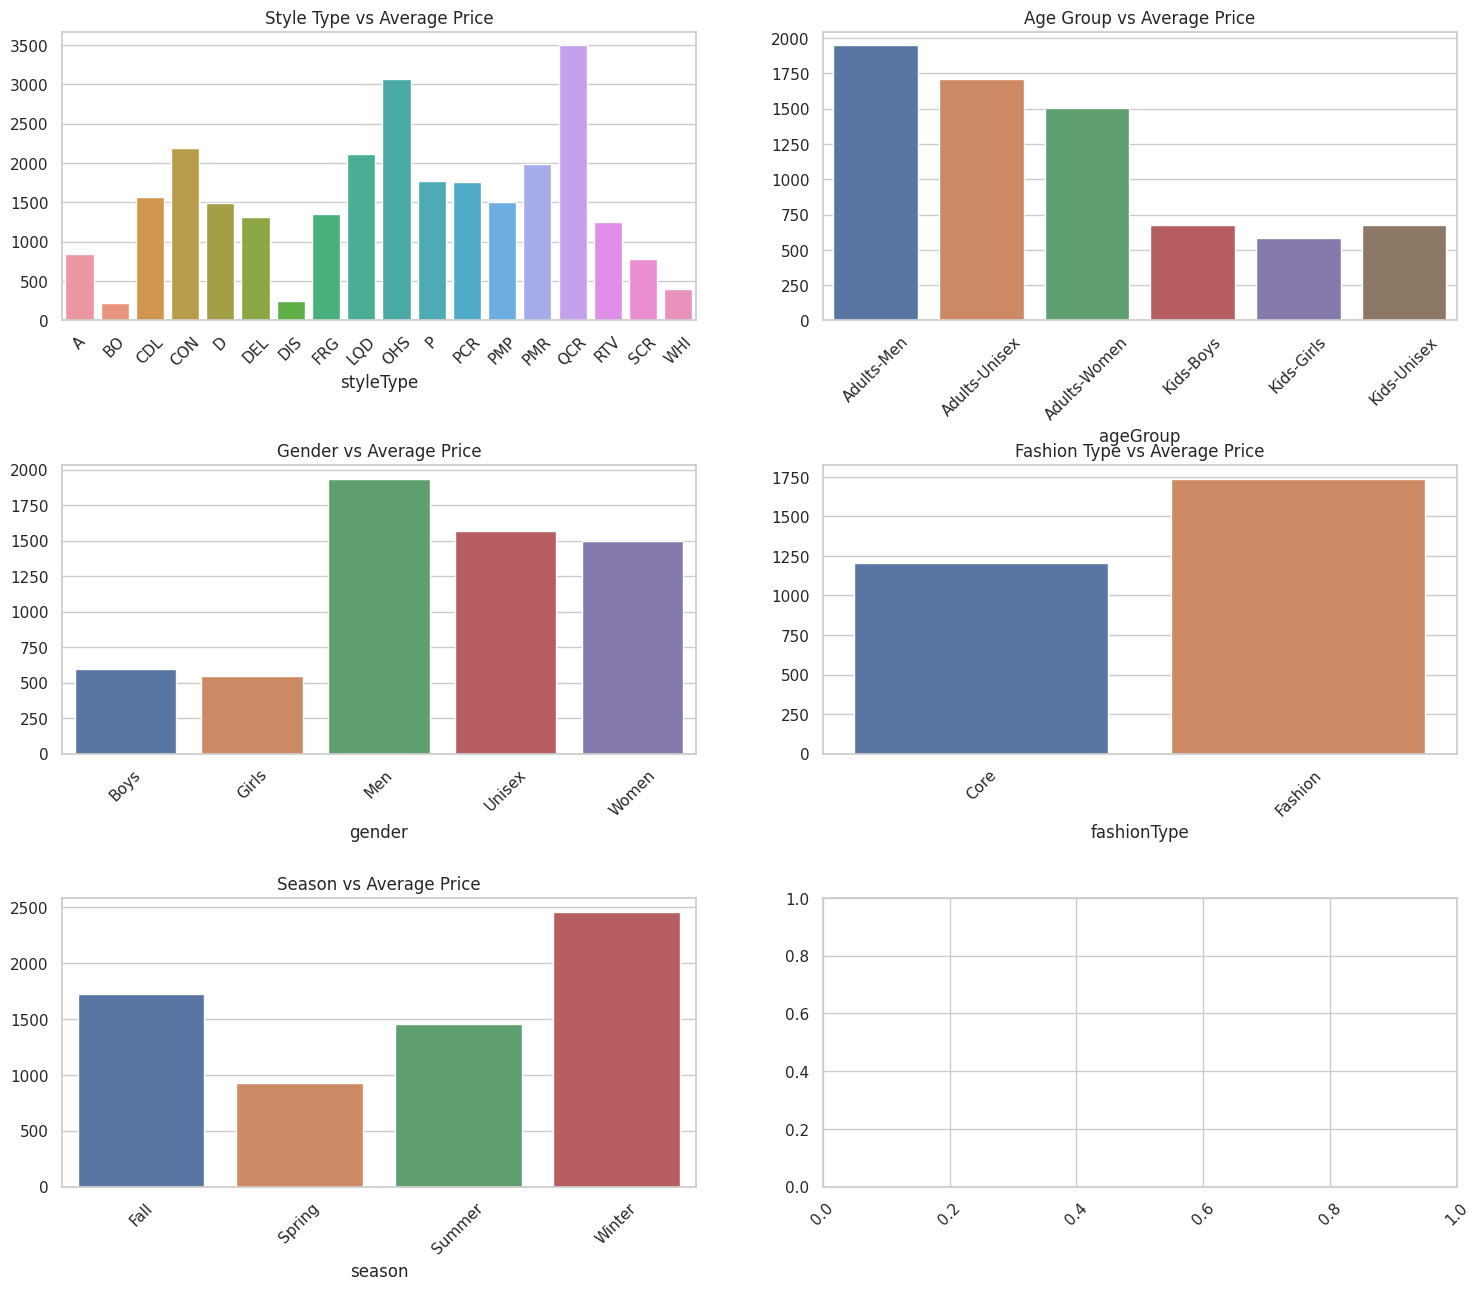

In [83]:
# Grouping data
style_dist = df.groupby('styleType')['price'].mean()
age_dist = df.groupby('ageGroup')['price'].mean()
gender_dist = df.groupby('gender')['price'].mean()
ft_dist = df.groupby('fashionType')['price'].mean()
season_dist = df.groupby('season')['price'].mean()

# Creating subplots
fig, ax = plt.subplots(3, 2, figsize=(18, 15))

# Plotting each distribution
sns.barplot(x=style_dist.index, y=style_dist.values, ax=ax[0][0])
ax[0][0].set_title("Style Type vs Average Price")

sns.barplot(x=age_dist.index, y=age_dist.values, ax=ax[0][1])
ax[0][1].set_title("Age Group vs Average Price")

sns.barplot(x=gender_dist.index, y=gender_dist.values, ax=ax[1][0])
ax[1][0].set_title("Gender vs Average Price")

sns.barplot(x=ft_dist.index, y=ft_dist.values, ax=ax[1][1])
ax[1][1].set_title("Fashion Type vs Average Price")

sns.barplot(x=season_dist.index, y=season_dist.values, ax=ax[2][0])
ax[2][0].set_title("Season vs Average Price")

# Setting x-axis labels rotation
for i in range(3):
    for j in range(2):
        ax[i][j].tick_params(axis='x', labelrotation=45)

# Adjusting subplot layout
plt.subplots_adjust(hspace=0.5)

# Displaying the plot
plt.show()

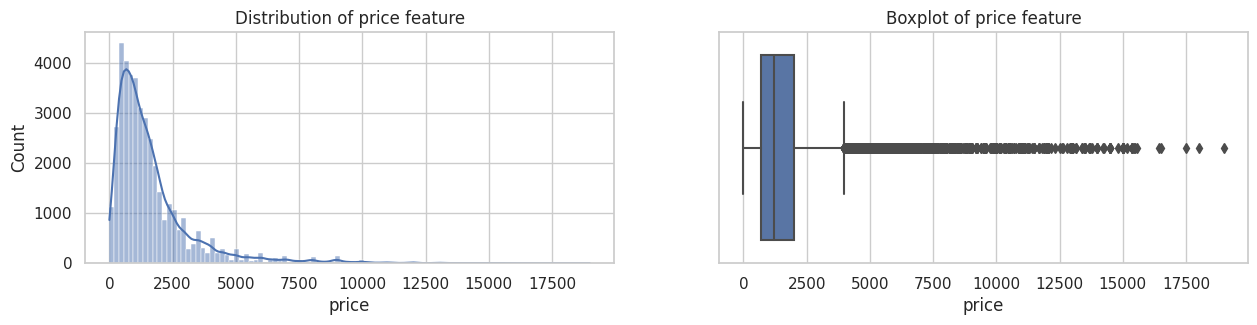

In [84]:
fig,ax = plt.subplots(1,2,figsize=(15,3))

sns.histplot(x=df['price'],kde=True,ax = ax[0],bins=100)
ax[0].set_title("Distribution of price feature")

sns.boxplot(x = df['price'],ax = ax[1])
ax[1].set_title("Boxplot of price feature")
plt.show()

In [ ]:
temp = df.groupby('vat')['price'].mean()
sns.barplot(y = temp.values,x = temp.index)

In [85]:
df.head(3)

,price,styleType,brandName,ageGroup,gender,baseColour,fashionType,season,usage,vat,isEMIEnabled,isReturnable,isExchangeable,discount_available
1,2199.0,P,FILA,Adults-Men,Men,Black,Core,Summer,Casual,14.5,True,True,True,False
2,2499.0,P,FILA,Adults-Men,Men,Black,Fashion,Fall,Sports,14.5,True,True,True,False
3,1695.0,RTV,Fossil,Adults-Men,Men,Black,Fashion,Fall,Casual,14.5,True,True,True,True


# Feature engineering

In [129]:
columns = ['isEMIEnabled','isReturnable','isExchangeable','discount_available']
for cols in columns:
    df[cols] = df[cols].astype(int)

In [100]:
temp = df.copy()

In [102]:
# Instantiating target encoder class
TE_styletype = ce.TargetEncoder()

# Fit the TargetEncoder to the training data
TE_styletype.fit(temp['styleType'], temp['price'])
temp['styleType'] = TE_styletype.transform(temp['styleType'])

In [103]:
# Instantiating target encoder class
TE_brandName = ce.TargetEncoder()

# Fit the TargetEncoder to the training data
TE_brandName.fit(temp['brandName'], temp['price'])
temp['brandName'] = TE_brandName.transform(temp['brandName'])

In [105]:
# Instantiating target encoder class
TE_baseColour = ce.TargetEncoder()

# Fit the TargetEncoder to the training data
TE_baseColour.fit(temp['baseColour'], temp['price'])
temp['baseColour'] = TE_baseColour.transform(temp['baseColour'])

In [109]:
fashiontype_encoded = pd.get_dummies(temp['fashionType'])
ageGroup_encoded = pd.get_dummies(temp['ageGroup'])
gender_encoded = pd.get_dummies(temp['gender'])
season_encoded = pd.get_dummies(temp['season'])
usage_encoded = pd.get_dummies(temp['usage'])

In [110]:
# Concatenate the encoded columns to the original DataFrame
temp = pd.concat([temp, fashiontype_encoded,ageGroup_encoded,gender_encoded,season_encoded,usage_encoded], axis=1)

In [112]:
temp.drop(['ageGroup','gender','fashionType','season','usage'],axis=1,inplace=True)

In [114]:
temp['isEMIEnabled'] = temp['isEMIEnabled'].astype(int)
temp['isReturnable'] = temp['isReturnable'].astype(int)
temp['isExchangeable'] = temp['isExchangeable'].astype(int)
temp['discount_available'] = temp['discount_available'].astype(int)

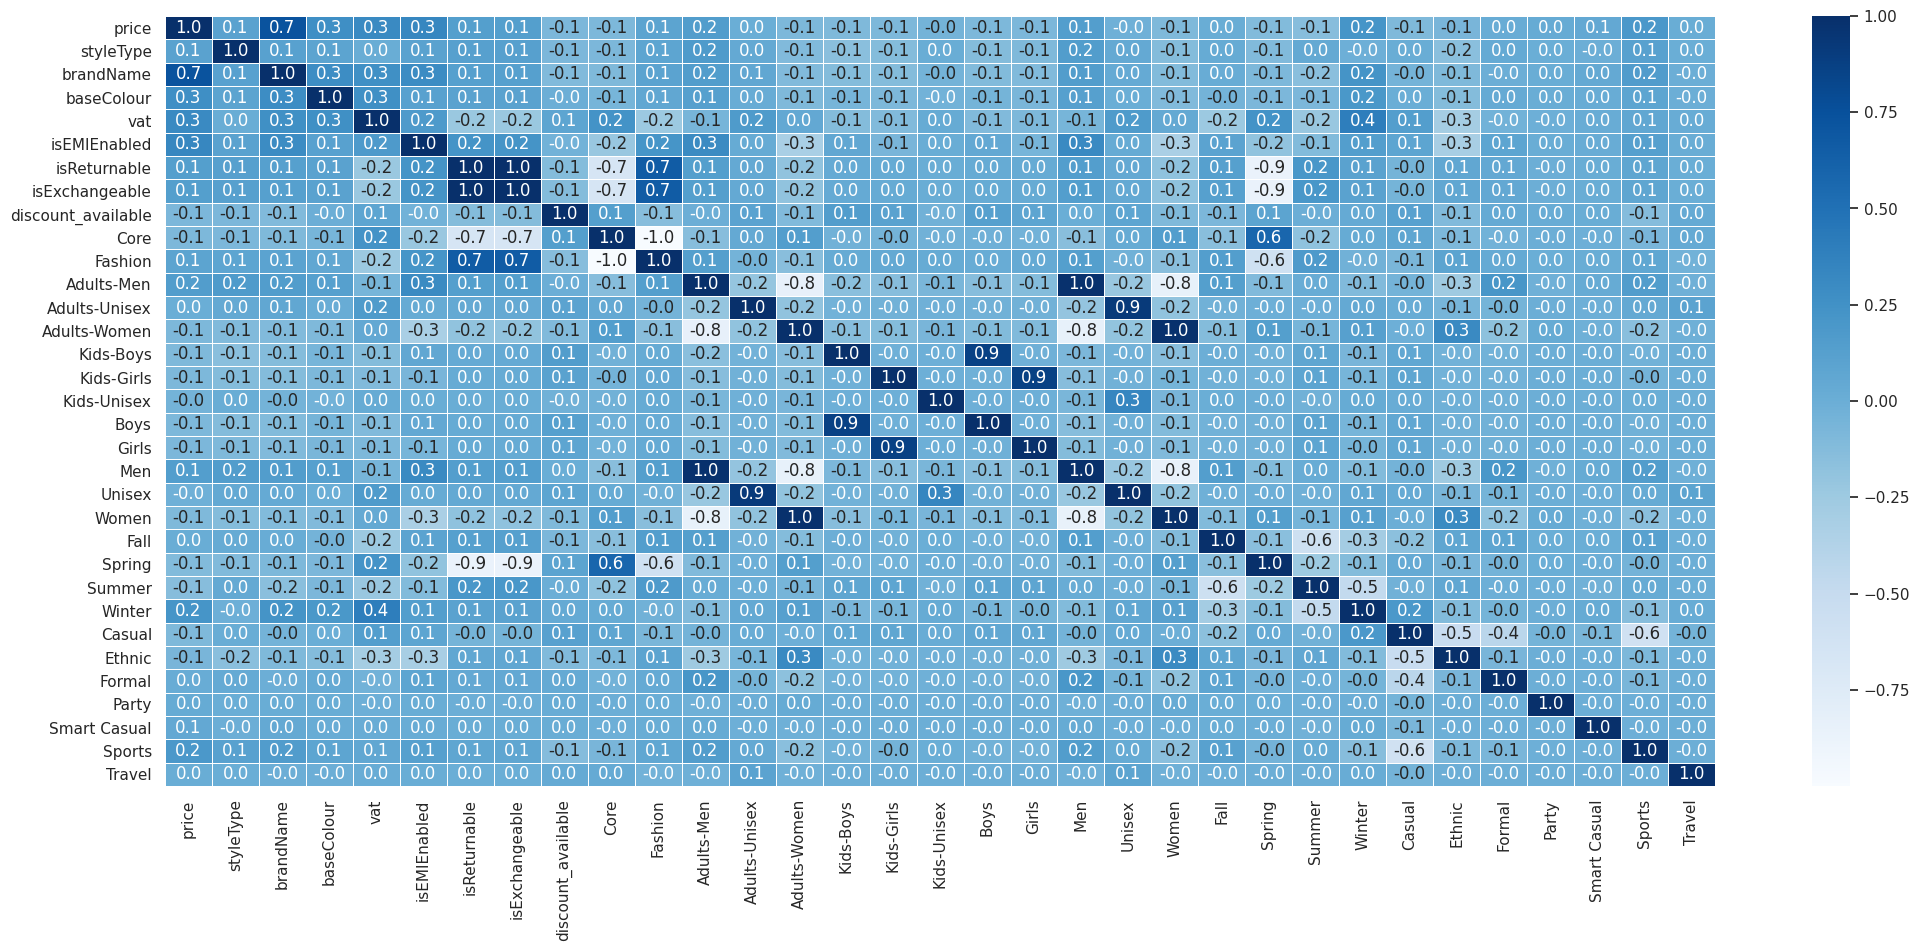

In [118]:
plt.figure(figsize=(25, 10))
sns.heatmap(temp.corr(),annot=True,cmap="Blues", fmt=".1f",linewidth=.5)
plt.show()

# Train test split

In [131]:
X = df.drop(['price'],axis=1)
y = df['price']

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8)
X_train.shape,X_test.shape

((33070, 13), (8268, 13))

In [132]:
X_train.head(5)

,styleType,brandName,ageGroup,gender,baseColour,fashionType,season,usage,vat,isEMIEnabled,isReturnable,isExchangeable,discount_available
121,P,Catwalk,Adults-Women,Women,Black,Fashion,Winter,Casual,14.5,1,1,1,0
3904,DEL,Lino Perros,Adults-Women,Women,Black,Fashion,Winter,Casual,14.5,0,1,1,0
18263,DEL,Gliders,Adults-Men,Men,Black,Fashion,Fall,Casual,14.5,0,1,1,0
42414,P,Jockey,Adults-Men,Men,Blue,Fashion,Summer,Casual,5.5,0,1,1,0
4098,P,Femella,Adults-Women,Women,Blue,Core,Summer,Casual,5.5,0,1,1,0


# Processing pipeline

In [133]:
# Instantiating target encoder class
TE_styletype = ce.TargetEncoder()
TE_brandName = ce.TargetEncoder()
TE_baseColour = ce.TargetEncoder()

TE_styletype.fit(X_train['styleType'], y_train)
TE_brandName.fit(X_train['brandName'], y_train)
TE_baseColour.fit(X_train['baseColour'], y_train)

X_train['styleType'] = TE_styletype.transform(X_train['styleType'])
X_train['brandName'] = TE_brandName.transform(X_train['brandName'])
X_train['baseColour'] = TE_baseColour.transform(X_train['baseColour'])

In [136]:
df['vat'].value_counts().index

Float64Index([5.5, 14.5, 0.0], dtype='float64')

In [134]:
X_train.head(4)

,styleType,brandName,ageGroup,gender,baseColour,fashionType,season,usage,vat,isEMIEnabled,isReturnable,isExchangeable,discount_available
121,1766.182800,1458.891844,Adults-Women,Women,2043.768856,Fashion,Winter,Casual,14.5,1,1,1,0
3904,1305.998215,1256.118957,Adults-Women,Women,2043.768856,Fashion,Winter,Casual,14.5,0,1,1,0
18263,1305.998215,1099.137601,Adults-Men,Men,2043.768856,Fashion,Fall,Casual,14.5,0,1,1,0
42414,1766.182800,278.194805,Adults-Men,Men,1433.111173,Fashion,Summer,Casual,5.5,0,1,1,0


In [ ]:
# Column transformer for doing ordinal and nominal encoding
encoding_transformer = ColumnTransformer(transformers = 
                                         
                    [('Encode_PropT',OneHotEncoder(handle_unknown='ignore',drop='first'),[0]),

                    ('Encode_balcony',OrdinalEncoder(categories=[['0','1','2','3','3+']],
                    handle_unknown="use_encoded_value",unknown_value = np.nan),[4]),
    
                    ('Encode_AgeP',OrdinalEncoder(categories=[['Under Construction','New Property','Relatively New', 
                    'Moderately Old','Old Property']],handle_unknown="use_encoded_value",unknown_value = np.nan),[5]),

                    ('Encode_Lux',OrdinalEncoder(categories=[['Low','Medium','High']],
                    handle_unknown="use_encoded_value",unknown_value = np.nan),[10]),

                    ('Encode_Floor',OrdinalEncoder(categories=[['Low Floor','Mid Floor','High Floor']],
                    handle_unknown="use_encoded_value",unknown_value = np.nan),[11])],remainder='passthrough')

# Column transformer for doing feature scaling
scaling_transformer = ColumnTransformer(transformers = [
    ('MinMaxScaling',MinMaxScaler(copy=False),[0,1,2,3,4,5,6,7,8,9,10,11])],remainder='passthrough')


# Stacking column transformers to create a Processing pipeline
Processing_pipeline = Pipeline(steps = [('Encoding',encoding_transformer),
                             ('Scaling',scaling_transformer)],memory='Temp')

# Model training

# Model evaluation